In [259]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from lxml import html
from lxml import etree
import lxml


from scipy.signal import savgol_filter
import statsmodels.api as sm
import pymc3 as pm
import statsmodels.api as sm
from statsmodels.tools import add_constant
from itertools import combinations

import matplotlib.pyplot as plt

# import seaborn
import seaborn as sns
# settings for seaborn plotting style
sns.set(color_codes=True)
# settings for seaborn plot sizes
sns.set(rc={'figure.figsize':(12,6)})

In [260]:
df2 = pd.read_csv("data/nfl_team_stats_2002-2023.csv")
df2.to_csv("data/nfl_team_stats_2002-2023.csv", index=False)
df2 = df2.copy()

In [261]:
df2['score_home'].dtype

dtype('int64')

In [262]:
# Convert score_home and score_away to numeric if they are strings
df2['score_home'] = pd.to_numeric(df2['score_home'], errors='coerce')
df2['score_away'] = pd.to_numeric(df2['score_away'], errors='coerce')

In [263]:
df2['score_away'].dtype

dtype('int64')

In [264]:
# Compute the score difference
df2['score_diff'] = df2['score_home'] - df2['score_away']

#### - '0' represents that the home team did not win(i.e. home team's score was less than away team)

#### - '1' represents that the home team did win(i.e. home team's score was greater than away team)

In [265]:
# Compute the winner column
df2['winner'] = (df2['score_home'] > df2['score_away']).astype(int)

In [266]:
df2['winner'].dtype

dtype('int64')

#####  Calculating Third-Down Percentages

In [267]:
# Calculate the third down completion percentage for the home team
df2['third_down_percentage_home'] = (df2['third_down_comp_home'] / df2['third_down_att_home']) * 100
df2['third_down_percentage_home'] = df2['third_down_percentage_home'].round(2)

df2['third_down_percentage_away'] = (df2['third_down_comp_away'] / df2['third_down_att_away']) * 100
df2['third_down_percentage_away'] = df2['third_down_percentage_away'].round(2)

In [268]:
df2.head()

,season,week,date,away,home,score_away,score_home,first_downs_away,first_downs_home,third_down_comp_away,...,interceptions_away,interceptions_home,def_st_td_away,def_st_td_home,possession_away,possession_home,score_diff,winner,third_down_percentage_home,third_down_percentage_away
0,2002,1,2002-09-05,49ers,Giants,16,13,13,21,4,...,1,3,0,0,27:32,32:28,-3,0,56.25,33.33
1,2002,1,2002-09-08,Jets,Bills,37,31,18,26,2,...,0,2,2,0,21:06,39:08,-6,0,41.18,25.00
2,2002,1,2002-09-08,Vikings,Bears,23,27,19,20,5,...,2,1,0,0,31:31,28:29,4,1,53.85,38.46
3,2002,1,2002-09-08,Chargers,Bengals,34,6,27,13,6,...,0,1,0,0,37:48,22:12,-28,0,36.36,60.00
4,2002,1,2002-09-08,Chiefs,Browns,40,39,24,24,5,...,1,0,0,0,30:16,29:44,-1,0,36.36,45.45


#####  Calculating Fourth-Down Percentages

In [269]:
df2['fourth_down_percentage_home'] = df2['fourth_down_comp_home'] / df2['fourth_down_att_home'].replace(0, np.nan) * 100
df2['fourth_down_percentage_home'] = df2['fourth_down_percentage_home'].round(2)

df2['fourth_down_percentage_away'] = df2['fourth_down_comp_away'] / df2['fourth_down_att_away'].replace(0, np.nan) * 100
df2['fourth_down_percentage_away'] = df2['fourth_down_percentage_away'].round(2)

# Optionally replace NaNs with 0 if desired
df2['fourth_down_percentage_home'].fillna(0, inplace=True)
df2['fourth_down_percentage_away'].fillna(0, inplace=True)

In [270]:
df2['sacks_num_home'].value_counts()

sacks_num_home
1     1429
2     1379
3     1044
0      854
4      642
5      316
6      153
7       71
8       26
9       10
11       3
10       2
Name: count, dtype: int64

In [271]:
# Create the new 'redzone_away' column by combining 'redzone_comp_away' and 'redzone_att_away'
df2['redzone_away'] = df2['redzone_comp_away'].astype(str) + '-' + df2['redzone_att_away'].astype(str)
# Display the updated DataFrame
print(df2[['redzone_comp_away', 'redzone_att_away', 'redzone_away']].head())

   redzone_comp_away  redzone_att_away redzone_away
0                  0                 8          0-8
1                  0                 9          0-9
2                  0                 7          0-7
3                  0                 7          0-7
4                  0                10         0-10


In [272]:
df2['redzone_percentage_home'] = df2['redzone_comp_home'] / df2['redzone_att_home'].replace(0, np.nan) * 100
df2['redzone_percentage_home'] = df2['redzone_percentage_home'].round(2)
df2['redzone_percentage_home'].fillna(0, inplace=True)

df2['redzone_percentage_away'] = df2['redzone_comp_away'] / df2['redzone_att_away'].replace(0, np.nan) * 100
df2['redzone_percentage_away'] = df2['redzone_percentage_away'].round(2)
df2['redzone_percentage_away'].fillna(0, inplace=True)

In [273]:
df2['redzone_percentage_home'].dtype

dtype('float64')

In [274]:
possession_away = df2['possession_away'].str.split(':', expand=True)
df2['possession_away'] = possession_away[0].to_numpy(dtype=float) * 60 + possession_away[1].to_numpy(dtype=float)

In [275]:
possession_home = df2['possession_home'].str.split(':', expand=True)
df2['possession_home'] = possession_home[0].to_numpy(dtype=float) * 60 + possession_home[1].to_numpy(dtype=float)

In [276]:
day_numbers = pd.to_numeric((pd.to_datetime(df2['date']) - pd.to_datetime(df2['date'][0])).dt.days,
                            downcast='integer')
years = np.ones(len(day_numbers))*2002
for idx in range(1,len(day_numbers)):
    years[idx] = years[idx-1] + ((day_numbers[idx]-day_numbers[idx-1]) > 30)*1
df2['season'] = years

In [277]:
# get basic info
nRows = df2.shape[0]
nCols = df2.shape[1]
column_names = list(df2.columns)

In [278]:
df2.drop('redzone_away', axis=1, inplace=True)

#### Create a column for total_yards_home and away

In [279]:
df2['total_yards_home'] = df2['pass_yards_home'] + df2['rush_yards_home']
df2['total_yards_home'] = df2['total_yards_home'].astype(float).fillna(0)
df2['total_yards_away'] = df2['pass_yards_away'] + df2['rush_yards_away']
df2['total_yards_away'] = df2['total_yards_away'].astype(float).fillna(0)

In [280]:
df2['total_yards_away'].describe

<bound method NDFrame.describe of 0       279.0
1       266.0
2       368.0
3       401.0
4       470.0
        ...  
5924    408.0
5925    361.0
5926    319.0
5927    442.0
5928    382.0
Name: total_yards_away, Length: 5929, dtype: float64>

#### Our column datatypes

In [281]:
df2['pass_yards_home'].describe

<bound method NDFrame.describe of 0       318
1       242
2       288
3       167
4       352
       ... 
5924    277
5925    186
5926    255
5927    258
5928    325
Name: pass_yards_home, Length: 5929, dtype: int64>

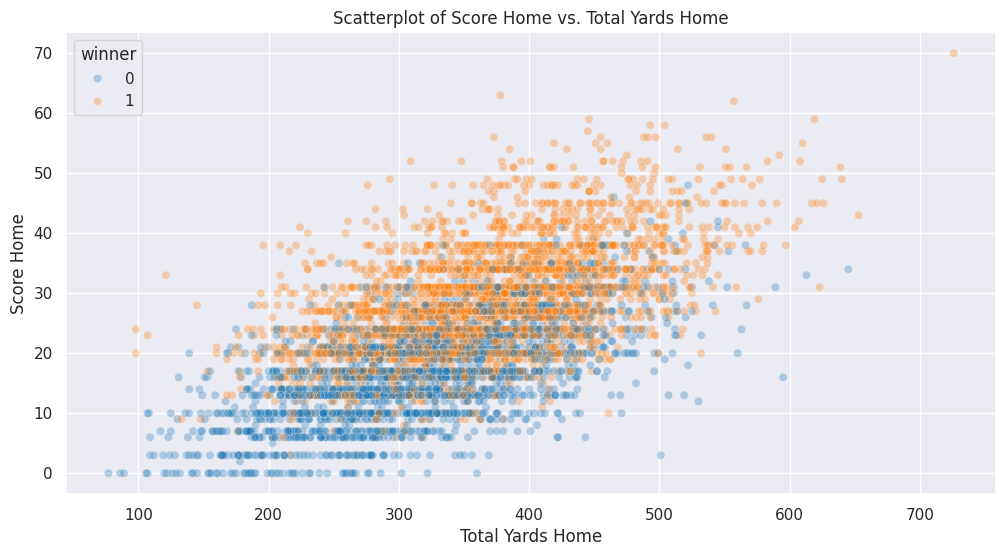

In [282]:
# Create scatter plot
sns.scatterplot(x=df2['total_yards_home'], y=df2['score_home'], alpha=0.3, hue=df2['winner'], palette='tab10')

# Add labels and title
plt.xlabel('Total Yards Home')
plt.ylabel('Score Home')
plt.title('Scatterplot of Score Home vs. Total Yards Home')

# Show plot
plt.show()

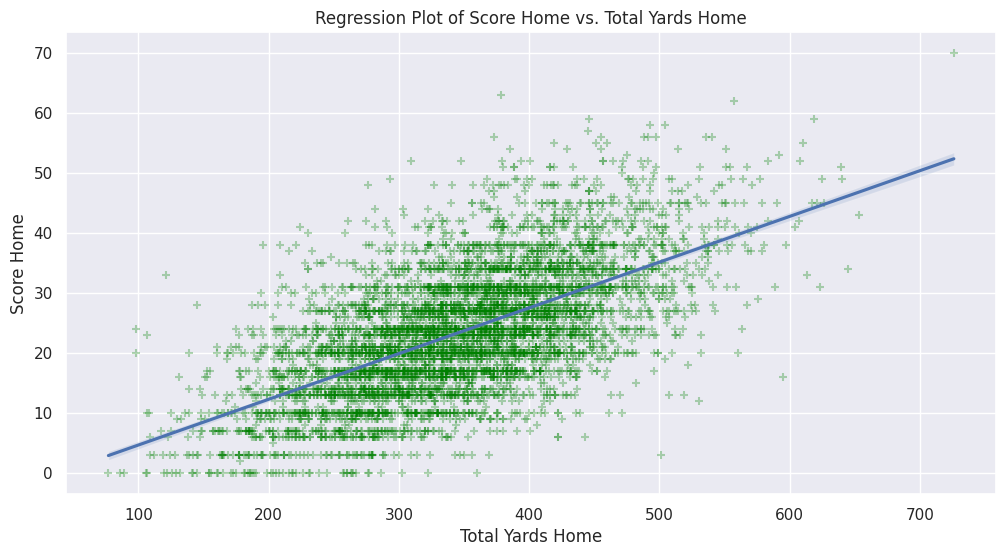

In [283]:
# Create regplot with regression line
sns.regplot(x=df2['total_yards_home'], y=df2['score_home'], marker="+", scatter_kws={'alpha':0.3, 'color':'green'})

# Add labels and title
plt.xlabel('Total Yards Home')
plt.ylabel('Score Home')
plt.title('Regression Plot of Score Home vs. Total Yards Home')

# Show plot
plt.show()

In [284]:
def bin_by(x, y, nbins=30, bins=None):
    # Divide the x-axis into sections and return groups of y based on its x value
    if bins is None:
        bins = np.linspace(x.min(), x.max(), nbins)  # Corrected function name here

    bin_space = (bins[-1] - bins[0]) / (len(bins) - 1) / 2
    indices = np.digitize(x, bins + bin_space)

    output = []
    for i in range(0, len(bins)):
        output.append(y[indices == i])

    df2_names = ['mean', 'median', '5th', '95th', '10th', '90th', '25th', '75th']
    rows = []  # Use a list to collect rows
    to_delete = []

    for y_set in output:
        if y_set.size > 0:
            av = y_set.mean()
            intervals = np.percentile(y_set, q=[50, 5, 95, 10, 90, 25, 75])
            res = [av] + list(intervals)
            rows.append(res)  # Append the row to the list
        else:
            to_delete.append(len(rows) + len(to_delete))

    df2 = pd.DataFrame(rows, columns=df2_names)  # Create DataFrame from the list of rows
    bins = np.delete(bins, to_delete)
    df2['x'] = bins

    return df2


def custom_percentile_plot(data, x_var, y_var, nbins):
    # generate random variables
    x,y = data[x_var],data[y_var]

    # bin the values and determine the envelopes
    df2 = bin_by(x, y, nbins=nbins, bins = None)

    # determine the colors
    cols = ['#EE7550', '#F19463', '#F6B176']

    with plt.style.context('fivethirtyeight'): 
        # plot the 3rd stdv
        plt.fill_between(df2.x, df2['5th'], df2['95th'], alpha=0.7,color = cols[2])
        plt.fill_between(df2.x, df2['10th'], df2['90th'], alpha=0.7,color = cols[1])
        plt.fill_between(df2.x, df2['25th'], df2['75th'], alpha=0.7,color = cols[0])
        # plt the line
        plt.plot(df2.x, df2['median'], color = '1', alpha = 0.7, linewidth = 1)
        # plot the points
        plt.scatter(x, y, facecolors='white', edgecolors='0', s = 5, lw = 0.7)
        plt.title('Percenile Plot (90%, 80%, and 50%)')
        plt.xlabel(x_var)
        plt.ylabel(y_var)

    plt.savefig('fig1.png', facecolor='white', edgecolor='none')
    plt.show()

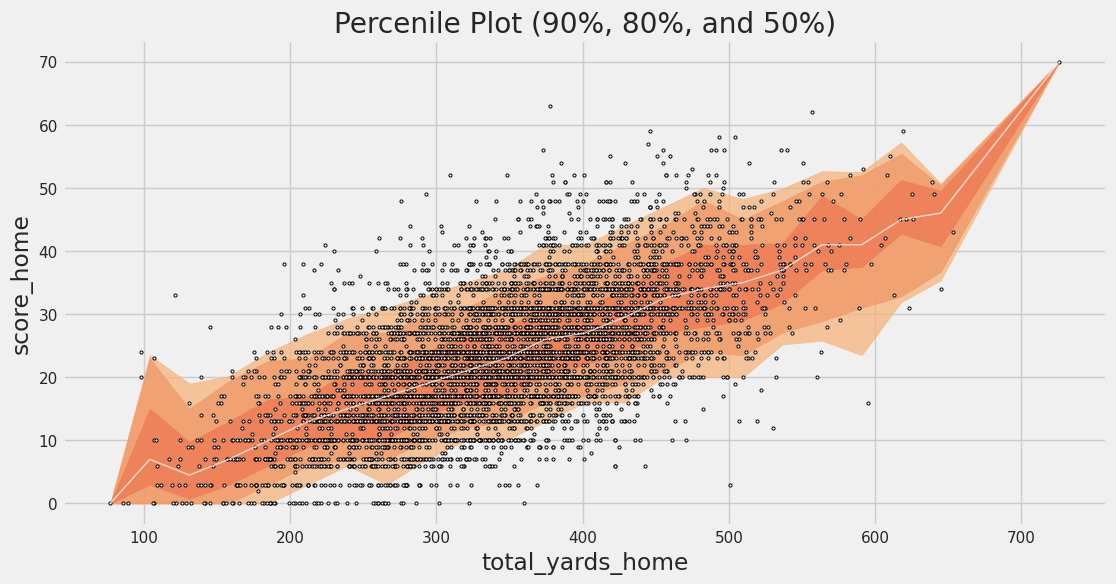

In [285]:
custom_percentile_plot(df2, 'total_yards_home', 'score_home', 25)

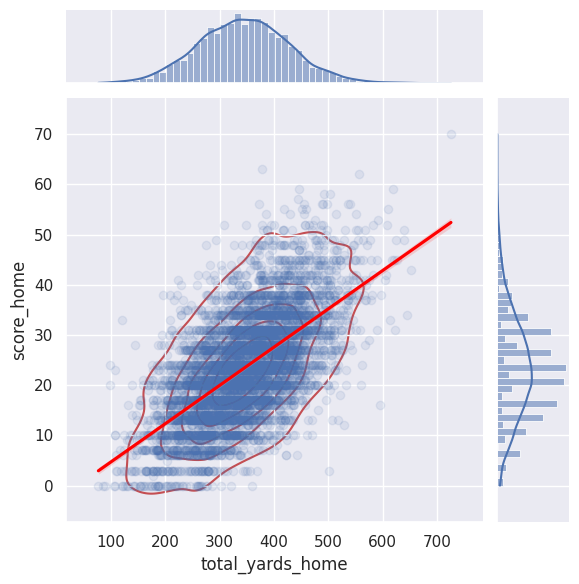

In [286]:
# jointplot, with both histograms and regression line in red
g = sns.jointplot(x=df2['total_yards_home'], y=df2['score_home'], kind='reg',
                  joint_kws={'line_kws':{'color':'red'}}, scatter_kws={'alpha':0.1}); 
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)

In [287]:
# make a linear regreesion model to predict the hom team score
model = sm.OLS(df2['score_home'], df2[['total_yards_home','total_yards_away']])
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             score_home   R-squared (uncentered):                   0.900
Model:                            OLS   Adj. R-squared (uncentered):              0.900
Method:                 Least Squares   F-statistic:                          2.659e+04
Date:                Fri, 16 Aug 2024   Prob (F-statistic):                        0.00
Time:                        18:34:44   Log-Likelihood:                         -20810.
No. Observations:                5929   AIC:                                  4.162e+04
Df Residuals:                    5927   BIC:                                  4.164e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
total_yards_home     0.0698      0.001     80.087      0.000       0.068       0.071
total_yards_away    -0.0017      0.001     -1.879      0.060      -0.003    7.34e-05
==============================================================================
Omnibus:                      117.183   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.550
Skew:                           0.327   Prob(JB):                     3.31e-28
Kurtosis:                       3.291   Cond. No.                         5.72
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

CONCLUSION: As expected, the score for the home team is strongly related to the # yards scored by the home team (p-score fo 0.000m ,coeff of 0.0696) but not strongly related to the yards by the aways team (p-score of 0.1, coeff of -0.0017). Each 10 additional yards gained by the home team corresponds to about 1/2 of an additional point.

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.93e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.

In [292]:
# make a linear regreesion model to predict the hom team score
model = sm.OLS(df2['winner'], df2.select_dtypes(['number']).drop(columns=['winner','score_diff','score_home','score_away']))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 winner   R-squared (uncentered):                   0.844
Model:                            OLS   Adj. R-squared (uncentered):              0.843
Method:                 Least Squares   F-statistic:                              624.1
Date:                Fri, 16 Aug 2024   Prob (F-statistic):                        0.00
Time:                        18:48:49   Log-Likelihood:                         -1205.4
No. Observations:                5929   AIC:                                      2513.
Df Residuals:                    5878   BIC:                                      2854.
Df Model:                          51                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
season                          0.0004   7.12e-05      4.923      0.000       0.000       0.000
first_downs_away                0.0037      0.003      1.342      0.180      -0.002       0.009
first_downs_home               -0.0041      0.003     -1.514      0.130      -0.009       0.001
third_down_comp_away           -0.0199      0.011     -1.776      0.076      -0.042       0.002
third_down_att_away             0.0219      0.006      3.433      0.001       0.009       0.034
third_down_comp_home            0.0206      0.011      1.878      0.060      -0.001       0.042
third_down_att_home            -0.0221      0.006     -3.464      0.001      -0.035      -0.010
fourth_down_comp_away          -0.0650      0.013     -5.143      0.000      -0.090      -0.040
fourth_down_att_away            0.0694      0.006     11.291      0.000       0.057       0.081
fourth_down_comp_home           0.0542      0.013      4.070      0.000       0.028       0.080
fourth_down_att_home           -0.0743      0.007    -11.415      0.000      -0.087      -0.062
plays_away                      0.0060      0.006      0.977      0.329      -0.006       0.018
plays_home                      0.0149      0.009      1.569      0.117      -0.004       0.033
drives_away                    -0.0160      0.003     -5.045      0.000      -0.022      -0.010
drives_home                     0.0154      0.003      4.698      0.000       0.009       0.022
yards_away                     -0.0003   3.99e-05     -7.177      0.000      -0.000      -0.000
yards_home                      0.0003   3.87e-05      7.503      0.000       0.000       0.000
pass_comp_away                 -0.0109      0.002     -5.817      0.000      -0.015      -0.007
pass_att_away                   0.0030      0.006      0.468      0.640      -0.010       0.016
pass_yards_away                -0.0006    6.9e-05     -8.027      0.000      -0.001      -0.000
pass_comp_home                  0.0124      0.002      6.679      0.000       0.009       0.016
pass_att_home                  -0.0244      0.010     -2.519      0.012      -0.043      -0.005
pass_yards_home                 0.0005   6.62e-05      7.532      0.000       0.000       0.001
sacks_num_away                 -0.0014      0.008     -0.175      0.861      -0.017       0.014
sacks_yards_away                0.0003      0.001      0.459      0.647      -0.001       0.002
sacks_num_home                 -0.0225      0.011     -2.055      0.040      -0.044      -0.001
sacks_yards_home             1.065e-05      0.001      0.015      0.988      -0.001       0.001
rush_att_away                  -0.0207      0.006     -3.192      0.001      -0.033      -0.008
rush_yar

#### List all the features.

In [296]:
feature_names = ''
for feature_name in df2.columns:
    feature_names = feature_names+' | '+feature_name
print(feature_names)

 | season | week | date | away | home | score_away | score_home | first_downs_away | first_downs_home | third_down_comp_away | third_down_att_away | third_down_comp_home | third_down_att_home | fourth_down_comp_away | fourth_down_att_away | fourth_down_comp_home | fourth_down_att_home | plays_away | plays_home | drives_away | drives_home | yards_away | yards_home | pass_comp_away | pass_att_away | pass_yards_away | pass_comp_home | pass_att_home | pass_yards_home | sacks_num_away | sacks_yards_away | sacks_num_home | sacks_yards_home | rush_att_away | rush_yards_away | rush_att_home | rush_yards_home | pen_num_away | pen_yards_away | pen_num_home | pen_yards_home | redzone_comp_away | redzone_att_away | redzone_comp_home | redzone_att_home | fumbles_away | fumbles_home | interceptions_away | interceptions_home | def_st_td_away | def_st_td_home | possession_away | possession_home | score_diff | winner | third_down_percentage_home | third_down_percentage_away | fourth_down_percentage_hom

#### Build per-team data frame

In [297]:
team_names = np.unique(df2.away)
print(team_names)

['49ers' 'Bears' 'Bengals' 'Bills' 'Broncos' 'Browns' 'Buccaneers'
 'Cardinals' 'Chargers' 'Chiefs' 'Colts' 'Commanders' 'Cowboys' 'Dolphins'
 'Eagles' 'Falcons' 'Giants' 'Jaguars' 'Jets' 'Lions' 'Packers' 'Panthers'
 'Patriots' 'Raiders' 'Rams' 'Ravens' 'Saints' 'Seahawks' 'Steelers'
 'Texans' 'Titans' 'Vikings']


In [298]:
df2.head()

,season,week,date,away,home,score_away,score_home,first_downs_away,first_downs_home,third_down_comp_away,...,score_diff,winner,third_down_percentage_home,third_down_percentage_away,fourth_down_percentage_home,fourth_down_percentage_away,redzone_percentage_home,redzone_percentage_away,total_yards_home,total_yards_away
0,2002.0,1,2002-09-05,49ers,Giants,16,13,13,21,4,...,-3,0,56.25,33.33,0.0,0.0,0.0,0.0,361.0,279.0
1,2002.0,1,2002-09-08,Jets,Bills,37,31,18,26,2,...,-6,0,41.18,25.00,100.0,0.0,0.0,0.0,384.0,266.0
2,2002.0,1,2002-09-08,Vikings,Bears,23,27,19,20,5,...,4,1,53.85,38.46,0.0,0.0,0.0,0.0,368.0,368.0
3,2002.0,1,2002-09-08,Chargers,Bengals,34,6,27,13,6,...,-28,0,36.36,60.00,0.0,0.0,0.0,0.0,203.0,401.0
4,2002.0,1,2002-09-08,Chiefs,Browns,40,39,24,24,5,...,-1,0,36.36,45.45,0.0,0.0,0.0,0.0,411.0,470.0


In [299]:
df_home = df2
df_away = df2
# create a column 'team' with team name and 'opponent' with the oponent temas name
df_home = df_home.rename({'home': 'team', 'away': 'opponent'}, axis=1)
df_away = df_away.rename({'away': 'team', 'home': 'opponent'}, axis=1)
# create a column 'home' determining if the game was home game
df_home['home'] = 'Y'
df_away['home'] = 'N'
# rename the columns to reflect team and opponent instead of home and away
for name in column_names[3:]:
    if 'home' in name:
        df_home = df_home.rename({name: name.replace('_home','')}, axis=1)
        df_away = df_away.rename({name: name.replace('_home','_opp')}, axis=1)
    else:
        df_home = df_home.rename({name: name.replace('_away','_opp')}, axis=1)
        df_away = df_away.rename({name: name.replace('_away','')}, axis=1)
        
df_away['winner'] = 1-df_away['winner']
df_away['score_diff'] = -df_away['score_diff']

df = pd.concat([df_home,df_away])
df['day_number'] = pd.to_numeric((pd.to_datetime(df['date']) - pd.to_datetime(df2['date'][0])).dt.days, downcast='integer')
df.sort_values(by=['day_number'], inplace=True)

In [301]:
# check that there are no NaNs
df2.columns[df2.isna().any()].tolist()

[]

In [302]:
df2.head()

,season,week,date,away,home,score_away,score_home,first_downs_away,first_downs_home,third_down_comp_away,...,score_diff,winner,third_down_percentage_home,third_down_percentage_away,fourth_down_percentage_home,fourth_down_percentage_away,redzone_percentage_home,redzone_percentage_away,total_yards_home,total_yards_away
0,2002.0,1,2002-09-05,49ers,Giants,16,13,13,21,4,...,-3,0,56.25,33.33,0.0,0.0,0.0,0.0,361.0,279.0
1,2002.0,1,2002-09-08,Jets,Bills,37,31,18,26,2,...,-6,0,41.18,25.00,100.0,0.0,0.0,0.0,384.0,266.0
2,2002.0,1,2002-09-08,Vikings,Bears,23,27,19,20,5,...,4,1,53.85,38.46,0.0,0.0,0.0,0.0,368.0,368.0
3,2002.0,1,2002-09-08,Chargers,Bengals,34,6,27,13,6,...,-28,0,36.36,60.00,0.0,0.0,0.0,0.0,203.0,401.0
4,2002.0,1,2002-09-08,Chiefs,Browns,40,39,24,24,5,...,-1,0,36.36,45.45,0.0,0.0,0.0,0.0,411.0,470.0


In [303]:
df_home.head()

,season,week,date,opponent,team,score_opp,score,first_downs_opp,first_downs,third_down_comp_opp,...,winner,third_down_percentage,third_down_percentage_opp,fourth_down_percentage,fourth_down_percentage_opp,redzone_percentage,redzone_percentage_opp,total_yards_home,total_yards_away,home
0,2002.0,1,2002-09-05,49ers,Giants,16,13,13,21,4,...,0,56.25,33.33,0.0,0.0,0.0,0.0,361.0,279.0,Y
1,2002.0,1,2002-09-08,Jets,Bills,37,31,18,26,2,...,0,41.18,25.00,100.0,0.0,0.0,0.0,384.0,266.0,Y
2,2002.0,1,2002-09-08,Vikings,Bears,23,27,19,20,5,...,1,53.85,38.46,0.0,0.0,0.0,0.0,368.0,368.0,Y
3,2002.0,1,2002-09-08,Chargers,Bengals,34,6,27,13,6,...,0,36.36,60.00,0.0,0.0,0.0,0.0,203.0,401.0,Y
4,2002.0,1,2002-09-08,Chiefs,Browns,40,39,24,24,5,...,0,36.36,45.45,0.0,0.0,0.0,0.0,411.0,470.0,Y


In [304]:
df_away.head()

,season,week,date,team,opponent,score,score_opp,first_downs,first_downs_opp,third_down_comp,...,winner,third_down_percentage_opp,third_down_percentage,fourth_down_percentage_opp,fourth_down_percentage,redzone_percentage_opp,redzone_percentage,total_yards_home,total_yards_away,home
0,2002.0,1,2002-09-05,49ers,Giants,16,13,13,21,4,...,1,56.25,33.33,0.0,0.0,0.0,0.0,361.0,279.0,N
1,2002.0,1,2002-09-08,Jets,Bills,37,31,18,26,2,...,1,41.18,25.00,100.0,0.0,0.0,0.0,384.0,266.0,N
2,2002.0,1,2002-09-08,Vikings,Bears,23,27,19,20,5,...,0,53.85,38.46,0.0,0.0,0.0,0.0,368.0,368.0,N
3,2002.0,1,2002-09-08,Chargers,Bengals,34,6,27,13,6,...,1,36.36,60.00,0.0,0.0,0.0,0.0,203.0,401.0,N
4,2002.0,1,2002-09-08,Chiefs,Browns,40,39,24,24,5,...,1,36.36,45.45,0.0,0.0,0.0,0.0,411.0,470.0,N


#### Create the per-team data frames

In [305]:
team_results = {}
team_results_avg = {}     
for name in team_names:
    team_results[name] = df.loc[df['team'] == name].sort_values(by=['day_number'], inplace=False)
    team_results_avg[name] = df.loc[df['team'] == name].sort_values(by=['day_number'], inplace=False)

In [306]:
# check the result
team_results['Bills']

,season,week,date,opponent,team,score_opp,score,first_downs_opp,first_downs,third_down_comp_opp,...,third_down_percentage,third_down_percentage_opp,fourth_down_percentage,fourth_down_percentage_opp,redzone_percentage,redzone_percentage_opp,total_yards_home,total_yards_away,home,day_number
1,2002.0,1,2002-09-08,Jets,Bills,37,31,18,26,2,...,41.18,25.00,100.00,0.0,0.00,0.00,384.0,266.0,Y,3
27,2002.0,2,2002-09-15,Vikings,Bills,39,45,31,26,7,...,33.33,43.75,0.00,100.0,0.00,0.00,449.0,468.0,N,10
39,2002.0,3,2002-09-22,Broncos,Bills,28,23,22,17,3,...,42.86,23.08,0.00,50.0,0.00,0.00,342.0,291.0,N,17
46,2002.0,4,2002-09-29,Bears,Bills,27,33,15,26,6,...,45.45,42.86,0.00,0.0,0.00,0.00,410.0,240.0,Y,24
61,2002.0,5,2002-10-06,Raiders,Bills,49,31,24,29,6,...,46.67,46.15,100.00,0.0,0.00,0.00,479.0,495.0,Y,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5870,2023.0,16,2023-12-23,Chargers,Bills,22,24,18,16,4,...,50.00,28.57,0.00,0.0,66.67,33.33,273.0,335.0,N,7779
5886,2023.0,17,2023-12-31,Patriots,Bills,21,27,16,19,4,...,46.67,40.00,0.00,0.0,40.00,100.00,281.0,294.0,Y,7787
5915,2023.0,18,2024-01-07,Dolphins,Bills,14,21,16,26,4,...,60.00,40.00,33.33,0.0,40.00,100.00,275.0,473.0,N,7794
5920,2023.0,Wildcard,2024-01-15,Steelers,Bills,17,31,22,24,5,...,41.67,45.45,100.00,0.0,66.67,66.67,368.0,324.0,Y,7802


#### Create a weighted average of previous games.

In [307]:
N = 20

column_indices_to_avg = np.where([x in team_results['Bills'].select_dtypes(['number']).columns for x in team_results['Bills'].columns])

for name in team_names:
    for idx in range(N,team_results[name].shape[0]):
        # Determine the days to the previous games, then weights for then weighted average.
        # Weights drop by about 7% for each previous week, or
        # by 90% going back to a previous season
        days = team_results[name].iloc[(idx-N):(idx-1)]['day_number'].to_numpy(dtype=float)
        days = days-days[-1]
        coeff = np.exp(days/200)/np.sum(np.exp(days/400))
        for col_idx in column_indices_to_avg:
            team_results_avg[name].iloc[idx,col_idx] = np.dot(coeff,team_results[name].iloc[(idx-N):(idx-1),col_idx])

In [308]:
team_results_avg['Bills'][['date','team','home','opponent','winner','score','score_opp','score_diff']]

,date,team,home,opponent,winner,score,score_opp,score_diff
1,2002-09-08,Bills,Y,Jets,0.000000,31.000000,37.000000,-6.000000
27,2002-09-15,Bills,N,Vikings,1.000000,45.000000,39.000000,6.000000
39,2002-09-22,Bills,N,Broncos,0.000000,23.000000,28.000000,-5.000000
46,2002-09-29,Bills,Y,Bears,1.000000,33.000000,27.000000,6.000000
61,2002-10-06,Bills,Y,Raiders,0.000000,31.000000,49.000000,-18.000000
...,...,...,...,...,...,...,...,...
5870,2023-12-23,Bills,N,Chargers,0.452800,21.485589,15.729899,5.755689
5886,2023-12-31,Bills,Y,Patriots,0.484721,22.158764,15.372529,6.786235
5915,2024-01-07,Bills,N,Dolphins,0.514909,22.219744,15.703752,6.515992
5920,2024-01-15,Bills,Y,Steelers,0.540281,22.332015,16.030330,6.301685
